# Задание №5. Школа информационной безопасности Яндекс 2018

Выполнил: Головенков Евгений.

Requirements: python2.7

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns  # графики
import matplotlib.pyplot as plt
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("shkib.csv", parse_dates=['_time'])

In [3]:
df.shape

(2394105, 9)

In [4]:
df.head()

,_time,src_user,src_ip,src_port,dest_user,dest_ip,dest_port,input_byte,output_byte
0,2018-01-19 16:46:00,c15cf96d9b56740c974661d209ef44f7,9ec3b27794d1d302fa04a94836249f4a,55991,NaN,1f1b55833917801cbd2ed9a313095d9e,443,1019,3562
1,2018-01-19 16:46:00,c15cf96d9b56740c974661d209ef44f7,9ec3b27794d1d302fa04a94836249f4a,55979,NaN,353a9f7687529bc37e3c8bcae6dcfdfa,443,840,357
2,2018-01-19 16:46:00,c15cf96d9b56740c974661d209ef44f7,9ec3b27794d1d302fa04a94836249f4a,34432,NaN,072f83db38ddd013e59a3616bd3b05a6,53,61,135
3,2018-01-19 16:46:00,c15cf96d9b56740c974661d209ef44f7,9ec3b27794d1d302fa04a94836249f4a,49932,NaN,072f83db38ddd013e59a3616bd3b05a6,53,61,77
4,2018-01-19 16:46:00,c15cf96d9b56740c974661d209ef44f7,9ec3b27794d1d302fa04a94836249f4a,55994,NaN,ee76d4dce963e690712339f7bf064705,443,757,3511


## Задача 1

Поиск 5ти пользователей, сгенерировавших наибольшее количество запросов

Найдем 5 самых активных пользователей

In [5]:
df['src_user'].value_counts().head(5)

a6c732a9cd426b7620cd93e7aa37aef6    54522
7834ea899abe21b5fd047e125cdffc56    50149
64c5eae485561a1d7064477e792a6358    46463
aedf2485753a52ca1149bde2343e8d7a    40371
e948e29d93d507d2bfd6dc2dee45bf2b    37718
Name: src_user, dtype: int64

## Задача 2

Поиск 5ти пользователей, отправивших наибольшее количество данных

In [6]:
df.groupby(df.src_user)['output_byte'].sum().sort_values(ascending=False).head(5)

src_user
ef407a4a8c7262284b558651b8e7eff3    5788762342
22e94d0520b9f9b2f02eaa97b165f720    2695498079
453370ebc5e3c98cc53664362da6cc1a    1560165694
34902a8b61bc416b1ff8832d7c3bbddb    1560156359
c15cf96d9b56740c974661d209ef44f7    1272035251
Name: output_byte, dtype: int64

## Задача 3

Поиск регулярных запросов (запросов выполняющихся периодически) по полю src_user

### Вариант 1. Агрегация только по полу src_user

In [7]:
# Составим список пользователей, т.е. список всех уникальных значений поля scr_user
users = df.groupby('src_user').count().reset_index()['src_user']
df.fillna('na', inplace=True)

In [8]:
# Будем работать только со строками, в которых присутствует поле scr_user 
l_users = list(users)
print("# of users: {}".format(len(l_users)))
df_users = df[df['src_user'].apply(lambda x: x in l_users)]

# Отсортируем все запросы по времени
df_users = df_users.sort_values(by='_time')

# of users: 322


In [9]:
# Найдем разницу во времени между запросами отдельно для каждого пользователя
df_users['time_delta'] = df_users['output_byte'].apply(lambda x: 0)
for user in l_users:
    df_users['time_delta'].update(df_users[df_users['src_user'] == user]['_time'].diff())

In [10]:
# Переведем все дельты в секунды
df_users['time_delta_sec'] = df_users['time_delta'] / np.timedelta64(1, 's')
df_users['time_delta_sec'].fillna(0, inplace=True)

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


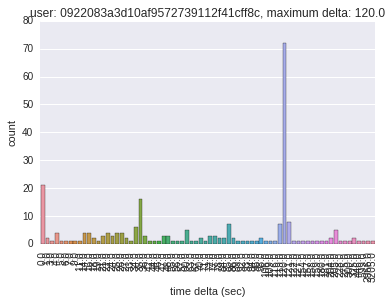

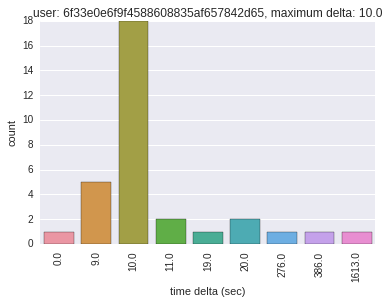

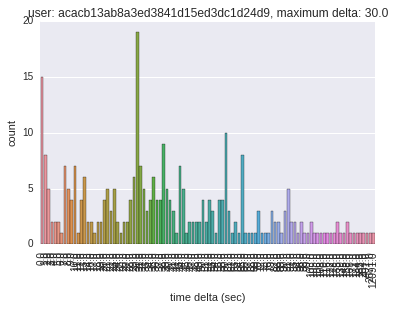

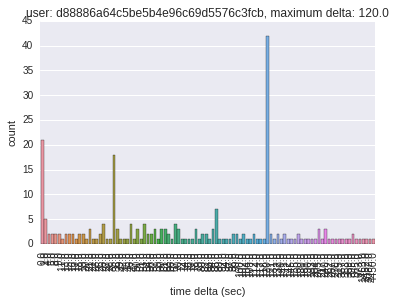

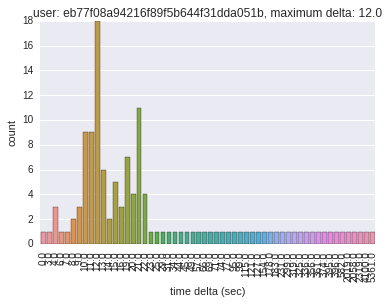

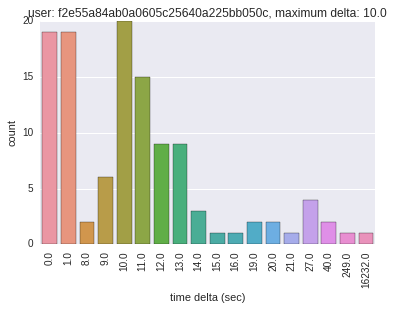

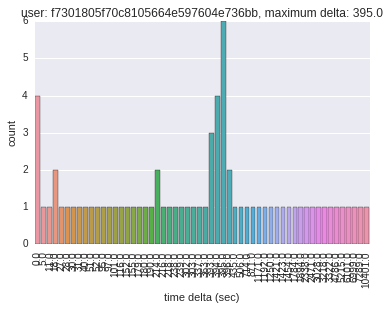

In [11]:
# Посчитаем распределение разниц во времени между соединениями для каждого пользователя 
#
# и запомним тех, у кого самое частое расстояние между запросами > 2 сек 
# и таких соединений было минимум 5, 
# т.е. кто чаще всего инициирует соединения периодически.
anomaly_users = []

for user in l_users:
    df_u = df_users[df_users['src_user'] == user]
    a_ = df_u.groupby('time_delta_sec')['_time'].count().sort_values(ascending=False)
    if a_.index[0] not in [0., 1., 2.] and a_[a_.index[0]] >= 5:
        anomaly_users.append(user)
        x = a_.reset_index()['time_delta_sec']
        y = a_.reset_index()['_time']
        plt.figure()
        ax = sns.barplot(x, y)
        ax.set_title("user: {}, maximum delta: {}".format(user, a_.index[0]))
        ax.set(xlabel='time delta (sec)', ylabel='count', )
        plt.setp(ax.get_xticklabels(), rotation=90)

In [12]:
anomaly_users

['0922083a3d10af9572739112f41cff8c',
 '6f33e0e6f9f4588608835af657842d65',
 'acacb13ab8a3ed3841d15ed3dc1d24d9',
 'd88886a64c5be5b4e96c69d5576c3fcb',
 'eb77f08a94216f89f5b644f31dda051b',
 'f2e55a84ab0a0605c25640a225bb050c',
 'f7301805f70c8105664e597604e736bb']

**Итог**

Можно заметить:
* у пользователя 0922083a3d10af9572739112f41cff8c больше 70 запросов с периодом в 120 секунд;
* у пользователя d88886a64c5be5b4e96c69d5576c3fcb больше 40 запросов с периодом в 120 секунд;
* у пользователя acacb13ab8a3ed3841d15ed3dc1d24d9 больше 16 запросов с периодом в 30 секунд.

Посмотрим на эти запросы подробнее:

In [13]:
df_users[(df_users['src_user'] == '0922083a3d10af9572739112f41cff8c') & (df_users['time_delta_sec'] == 120)]

,_time,src_user,src_ip,src_port,dest_user,dest_ip,dest_port,input_byte,output_byte,time_delta,time_delta_sec
1968116,2018-01-19 07:08:39,0922083a3d10af9572739112f41cff8c,81f46463c76942912a3db2ecdd698ec2,137,na,072f83db38ddd013e59a3616bd3b05a6,137,864,0,00:02:00,120.0
1893789,2018-01-19 07:39:13,0922083a3d10af9572739112f41cff8c,81f46463c76942912a3db2ecdd698ec2,137,na,072f83db38ddd013e59a3616bd3b05a6,137,864,0,00:02:00,120.0
1683389,2018-01-19 07:48:39,0922083a3d10af9572739112f41cff8c,81f46463c76942912a3db2ecdd698ec2,137,na,072f83db38ddd013e59a3616bd3b05a6,137,864,0,00:02:00,120.0
1899226,2018-01-19 07:50:39,0922083a3d10af9572739112f41cff8c,81f46463c76942912a3db2ecdd698ec2,137,na,072f83db38ddd013e59a3616bd3b05a6,137,864,0,00:02:00,120.0
1811506,2018-01-19 07:52:39,0922083a3d10af9572739112f41cff8c,81f46463c76942912a3db2ecdd698ec2,137,na,072f83db38ddd013e59a3616bd3b05a6,137,864,0,00:02:00,120.0
1683047,2018-01-19 07:55:13,0922083a3d10af9572739112f41cff8c,81f46463c76942912a3db2ecdd698ec2,137,na,072f83db38ddd013e59a3616bd3b05a6,137,864,0,00:02:00,120.0
1898371,2018-01-19 07:57:13,0922083a3d10af9572739112f41cff8c,81f46463c76942912a3db2ecdd698ec2,137,na,072f83db38ddd013e59a3616bd3b05a6,137,864,0,00:02:00,120.0
1862317,2018-01-19 08:08:39,0922083a3d10af9572739112f41cff8c,81f46463c76942912a3db2ecdd698ec2,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1800,0,00:02:00,120.0
1827464,2018-01-19 08:19:14,0922083a3d10af9572739112f41cff8c,81f46463c76942912a3db2ecdd698ec2,137,na,072f83db38ddd013e59a3616bd3b05a6,137,864,0,00:02:00,120.0
1837848,2018-01-19 08:21:14,0922083a3d10af9572739112f41cff8c,81f46463c76942912a3db2ecdd698ec2,137,na,072f83db38ddd013e59a3616bd3b05a6,137,864,0,00:02:00,120.0


In [14]:
df_users[(df_users['src_user'] == 'd88886a64c5be5b4e96c69d5576c3fcb') & (df_users['time_delta_sec'] == 120)]

,_time,src_user,src_ip,src_port,dest_user,dest_ip,dest_port,input_byte,output_byte,time_delta,time_delta_sec
1681943,2018-01-19 08:30:44,d88886a64c5be5b4e96c69d5576c3fcb,4b2d731a5b5cd18a95d217b891663ff4,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1728,0,00:02:00,120.0
1752464,2018-01-19 08:47:19,d88886a64c5be5b4e96c69d5576c3fcb,4b2d731a5b5cd18a95d217b891663ff4,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1728,0,00:02:00,120.0
1631091,2018-01-19 08:54:44,d88886a64c5be5b4e96c69d5576c3fcb,4b2d731a5b5cd18a95d217b891663ff4,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1728,0,00:02:00,120.0
1707008,2018-01-19 08:56:44,d88886a64c5be5b4e96c69d5576c3fcb,4b2d731a5b5cd18a95d217b891663ff4,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1632,0,00:02:00,120.0
1628811,2018-01-19 09:01:19,d88886a64c5be5b4e96c69d5576c3fcb,4b2d731a5b5cd18a95d217b891663ff4,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1728,0,00:02:00,120.0
1652860,2018-01-19 09:03:19,d88886a64c5be5b4e96c69d5576c3fcb,4b2d731a5b5cd18a95d217b891663ff4,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1728,0,00:02:00,120.0
1684057,2018-01-19 09:08:44,d88886a64c5be5b4e96c69d5576c3fcb,4b2d731a5b5cd18a95d217b891663ff4,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1728,0,00:02:00,120.0
1618365,2018-01-19 09:15:19,d88886a64c5be5b4e96c69d5576c3fcb,4b2d731a5b5cd18a95d217b891663ff4,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1728,0,00:02:00,120.0
1374796,2018-01-19 10:20:45,d88886a64c5be5b4e96c69d5576c3fcb,4b2d731a5b5cd18a95d217b891663ff4,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1728,0,00:02:00,120.0
1361402,2018-01-19 10:24:45,d88886a64c5be5b4e96c69d5576c3fcb,4b2d731a5b5cd18a95d217b891663ff4,137,na,072f83db38ddd013e59a3616bd3b05a6,137,1866,0,00:02:00,120.0


In [15]:
df_users[(df_users['src_user'] == 'acacb13ab8a3ed3841d15ed3dc1d24d9') & (df_users['time_delta_sec'] == 30)]

,_time,src_user,src_ip,src_port,dest_user,dest_ip,dest_port,input_byte,output_byte,time_delta,time_delta_sec
1311009,2018-01-19 10:31:53,acacb13ab8a3ed3841d15ed3dc1d24d9,8cf5d6184a1a386a179c1af6ecbb5a90,39330,e948e29d93d507d2bfd6dc2dee45bf2b,3f640ac7c2b8014b9601a80c5ccd1df2,631,780,0,00:00:30,30.0
1240666,2018-01-19 10:44:06,acacb13ab8a3ed3841d15ed3dc1d24d9,8cf5d6184a1a386a179c1af6ecbb5a90,40610,0f0c129694085ab9c5ad2e7a9c28378c,ddc69fecac929dce4a20d790a587fc7b,631,780,0,00:00:30,30.0
1271551,2018-01-19 10:45:47,acacb13ab8a3ed3841d15ed3dc1d24d9,8cf5d6184a1a386a179c1af6ecbb5a90,40628,0f0c129694085ab9c5ad2e7a9c28378c,ddc69fecac929dce4a20d790a587fc7b,631,720,0,00:00:30,30.0
1039594,2018-01-19 10:46:17,acacb13ab8a3ed3841d15ed3dc1d24d9,8cf5d6184a1a386a179c1af6ecbb5a90,40636,0f0c129694085ab9c5ad2e7a9c28378c,ddc69fecac929dce4a20d790a587fc7b,631,900,0,00:00:30,30.0
1232384,2018-01-19 10:50:11,acacb13ab8a3ed3841d15ed3dc1d24d9,8cf5d6184a1a386a179c1af6ecbb5a90,40604,0f0c129694085ab9c5ad2e7a9c28378c,ddc69fecac929dce4a20d790a587fc7b,631,300,0,00:00:30,30.0
1067332,2018-01-19 10:53:35,acacb13ab8a3ed3841d15ed3dc1d24d9,8cf5d6184a1a386a179c1af6ecbb5a90,40738,0f0c129694085ab9c5ad2e7a9c28378c,ddc69fecac929dce4a20d790a587fc7b,631,60,0,00:00:30,30.0
1132007,2018-01-19 10:58:37,acacb13ab8a3ed3841d15ed3dc1d24d9,8cf5d6184a1a386a179c1af6ecbb5a90,40698,0f0c129694085ab9c5ad2e7a9c28378c,ddc69fecac929dce4a20d790a587fc7b,631,300,0,00:00:30,30.0
1099874,2018-01-19 10:59:40,acacb13ab8a3ed3841d15ed3dc1d24d9,8cf5d6184a1a386a179c1af6ecbb5a90,40728,0f0c129694085ab9c5ad2e7a9c28378c,ddc69fecac929dce4a20d790a587fc7b,631,300,0,00:00:30,30.0
963088,2018-01-19 11:00:10,acacb13ab8a3ed3841d15ed3dc1d24d9,8cf5d6184a1a386a179c1af6ecbb5a90,40738,0f0c129694085ab9c5ad2e7a9c28378c,ddc69fecac929dce4a20d790a587fc7b,631,300,0,00:00:30,30.0
1154597,2018-01-19 11:04:07,acacb13ab8a3ed3841d15ed3dc1d24d9,8cf5d6184a1a386a179c1af6ecbb5a90,40792,0f0c129694085ab9c5ad2e7a9c28378c,ddc69fecac929dce4a20d790a587fc7b,631,300,0,00:00:30,30.0


Видим периодическую активность NETBIOS (для первых 2 пользователей) и CUPS (последнего).
Такая активность подозрительной не кажется.

### Вариант 2. Агрегация по паре (src_user, dest_ip)

Вышеуказанный подход не учитывает ситуации, когда периодически соединения с CnC теряются в плотном трафике пользователя, а именно, для отслеживания таких периодических соединений необходимо смотреть не только на **scr_user**, но на пару **(src_user, dest_ip)** и считать распределение времени для всех таких уникальных соединений  

In [16]:
# Составим список пар (src_user, dest_ip)
users2 = df.groupby(['src_user', 'dest_ip']).count().sort_values('_time', ascending=False).reset_index()[['src_user', 'dest_ip', '_time']]
users2.head()

,src_user,dest_ip,_time
0,7834ea899abe21b5fd047e125cdffc56,072f83db38ddd013e59a3616bd3b05a6,37386
1,a6c732a9cd426b7620cd93e7aa37aef6,0956783fe5a6d8e0f864b5eaf4084063,35092
2,f2825c1deb48cc723dc27b598c662610,0956783fe5a6d8e0f864b5eaf4084063,23520
3,64c5eae485561a1d7064477e792a6358,0956783fe5a6d8e0f864b5eaf4084063,16409
4,ea0ca94d54740e7b281feafe7954291a,0956783fe5a6d8e0f864b5eaf4084063,14162


In [17]:
print("Уникальных пар: {}".format(users2.shape[0]))

Уникальных пар: 55707


In [18]:
users2['u_ip_pair'] = users2.apply(lambda row: "{} {}".format(row['src_user'], row['dest_ip']), axis=1)

In [19]:
l_user_ip_pair = list(users2['u_ip_pair'])

In [20]:
len(l_user_ip_pair)

55707

In [21]:
users2.head()

,src_user,dest_ip,_time,u_ip_pair
0,7834ea899abe21b5fd047e125cdffc56,072f83db38ddd013e59a3616bd3b05a6,37386,7834ea899abe21b5fd047e125cdffc56 072f83db38ddd...
1,a6c732a9cd426b7620cd93e7aa37aef6,0956783fe5a6d8e0f864b5eaf4084063,35092,a6c732a9cd426b7620cd93e7aa37aef6 0956783fe5a6d...
2,f2825c1deb48cc723dc27b598c662610,0956783fe5a6d8e0f864b5eaf4084063,23520,f2825c1deb48cc723dc27b598c662610 0956783fe5a6d...
3,64c5eae485561a1d7064477e792a6358,0956783fe5a6d8e0f864b5eaf4084063,16409,64c5eae485561a1d7064477e792a6358 0956783fe5a6d...
4,ea0ca94d54740e7b281feafe7954291a,0956783fe5a6d8e0f864b5eaf4084063,14162,ea0ca94d54740e7b281feafe7954291a 0956783fe5a6d...


In [22]:
# Отсортируем все запросы по времени
df_user_ip_pair = df[(df.src_user != 'na') & (df.dest_ip != 'na')].sort_values(by='_time')

In [23]:
df_user_ip_pair.shape

(2097911, 9)

In [24]:
# Найдем разницу во времени между запросами отдельно для каждой пары 
# Начнем с наиболее встречающихся пар
df_user_ip_pair['time_delta'] = df_user_ip_pair['output_byte'].apply(lambda x: 0)
for i, pair in enumerate(l_user_ip_pair[:1000]): # для ускорения обработки можно ограничиться первыми n: l_user_ip_pair[:1000]
    user, ip = pair.split(' ')
    df_user_ip_pair['time_delta'].update(df_user_ip_pair[(df_user_ip_pair.src_user == user) & (df_user_ip_pair.dest_ip == ip)]['_time'].diff())

In [25]:
# Переведем все дельты в секунды
df_user_ip_pair['time_delta_sec'] = df_user_ip_pair['time_delta'] / np.timedelta64(1, 's')
df_user_ip_pair['time_delta_sec'].fillna(0, inplace=True)

In [26]:
df_user_ip_pair

,_time,src_user,src_ip,src_port,dest_user,dest_ip,dest_port,input_byte,output_byte,time_delta,time_delta_sec
2392245,2018-01-18 18:00:00,efdb5488cc509caff4c2de4654240f9d,f32ed332994d599e45b8bdbfc8d1da7d,57642,na,fcd0434af03dc92feebc396d5315bd80,143,2070,2566,00:00:00,0.0
2386236,2018-01-18 18:00:00,f2825c1deb48cc723dc27b598c662610,43ed6a1c781031fa618c0350a801e52f,37728,na,0956783fe5a6d8e0f864b5eaf4084063,53,140,184,00:00:00,0.0
2386235,2018-01-18 18:00:00,f2825c1deb48cc723dc27b598c662610,43ed6a1c781031fa618c0350a801e52f,41564,na,e3ec35262a27486da55813ba91a9b34b,443,579,2678,00:00:00,0.0
2386234,2018-01-18 18:00:00,efb71bb54879e4f0a442fb1c0a8de8a6,d2755b88076adf51aa1faeca46c317ac,61488,na,b24a569f301f0835581dd4ce52583f8c,3030,5448,1114,00:00:00,0.0
2392244,2018-01-18 18:00:00,3f341362e80f676a3602d726e73ef94d,45c9c56fc54a8549b6a4ed19c97bbaf5,49888,na,e3ec35262a27486da55813ba91a9b34b,443,0,157,00:00:00,0.0
2391211,2018-01-18 18:00:01,f4ab97f25385cd74e8c7537b55a497f8,bb589aebeb6b1a45d2b9bbfa108f0f30,36047,na,0956783fe5a6d8e0f864b5eaf4084063,53,124,188,00:00:00,0.0
2386233,2018-01-18 18:00:01,f4ab97f25385cd74e8c7537b55a497f8,bb589aebeb6b1a45d2b9bbfa108f0f30,36047,na,072f83db38ddd013e59a3616bd3b05a6,53,124,188,00:00:00,0.0
2386232,2018-01-18 18:00:01,f2825c1deb48cc723dc27b598c662610,43ed6a1c781031fa618c0350a801e52f,53146,na,0956783fe5a6d8e0f864b5eaf4084063,53,140,0,00:00:01,1.0
2391210,2018-01-18 18:00:02,32205ebe3150a6f1bed5363a2796f316,de465c50e6d5c5935b566c850652f067,47544,na,0fcf08000d8647525fd0b5e7b61ed94e,443,52,52,00:00:00,0.0
2391209,2018-01-18 18:00:02,0f0c129694085ab9c5ad2e7a9c28378c,ddc69fecac929dce4a20d790a587fc7b,26216,na,0956783fe5a6d8e0f864b5eaf4084063,53,71,99,00:00:00,0.0


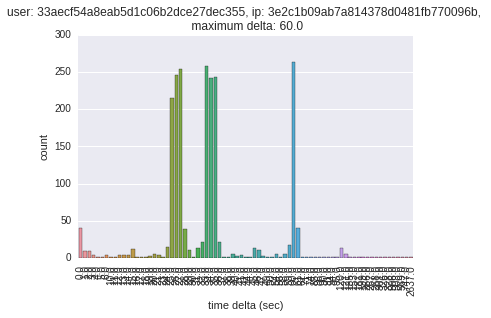

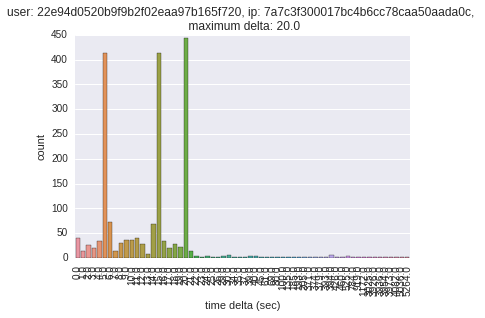

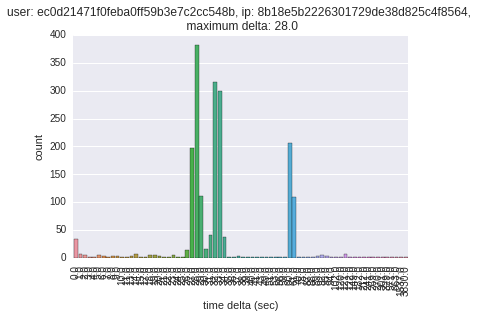

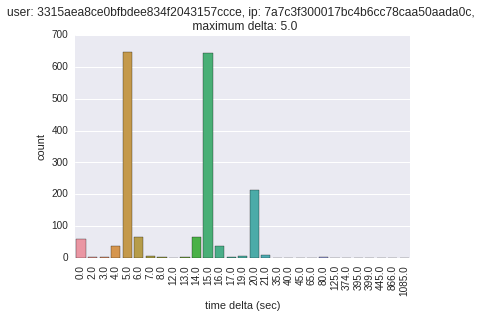

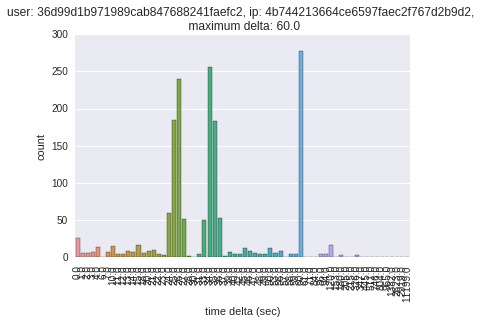

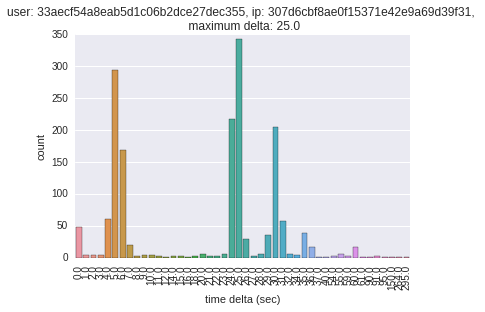

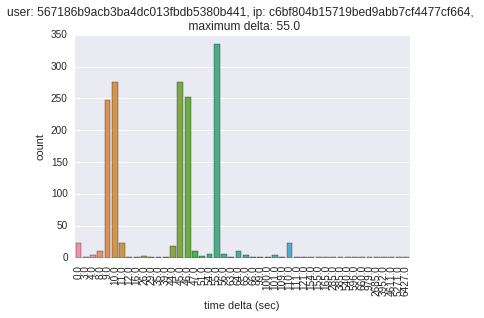

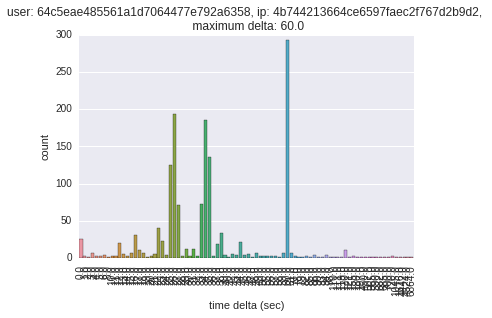

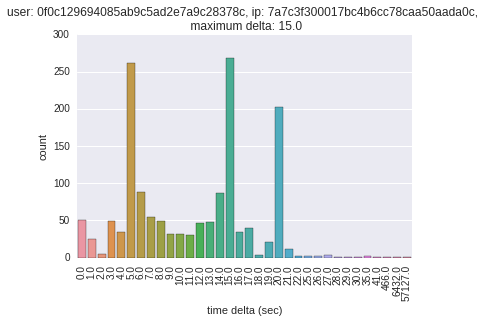

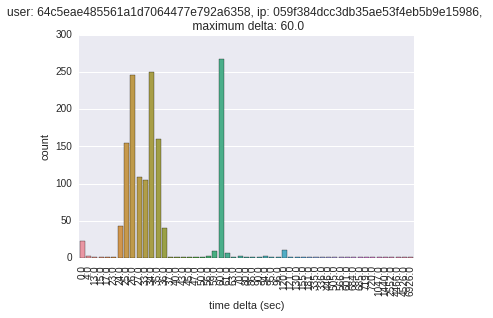

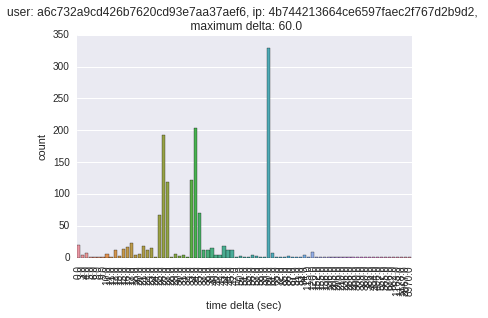

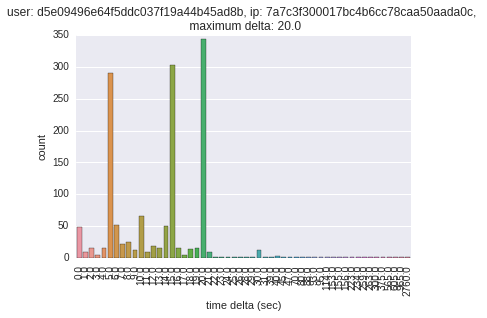

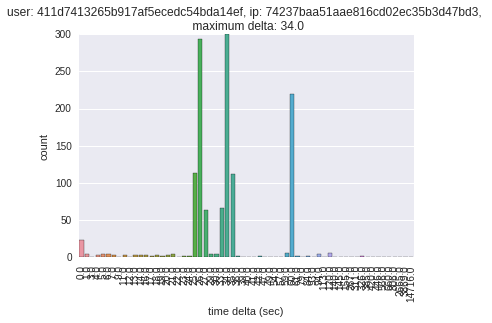

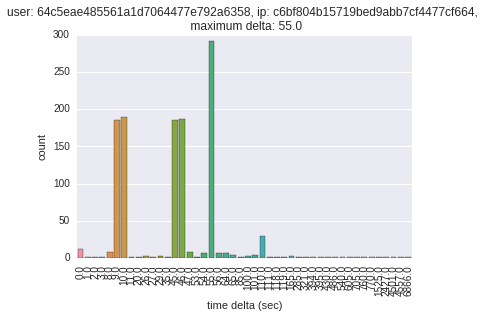

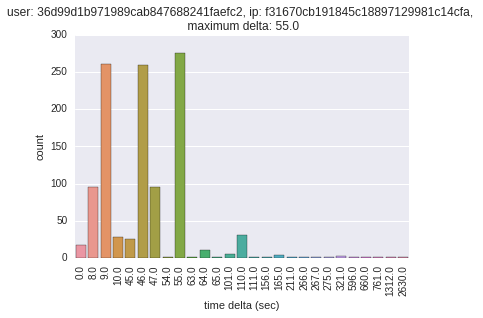

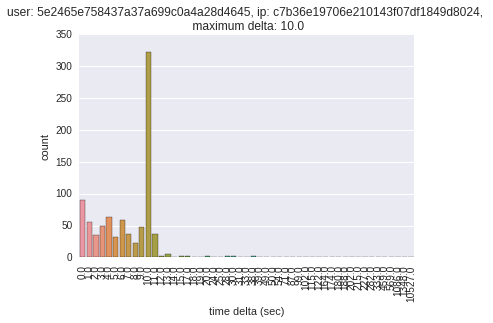

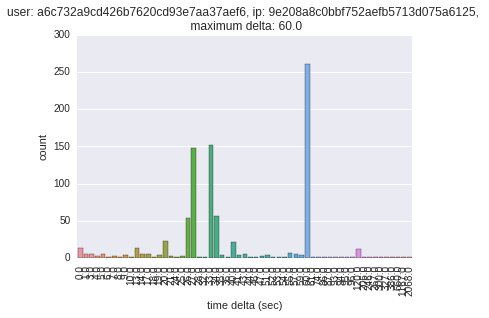

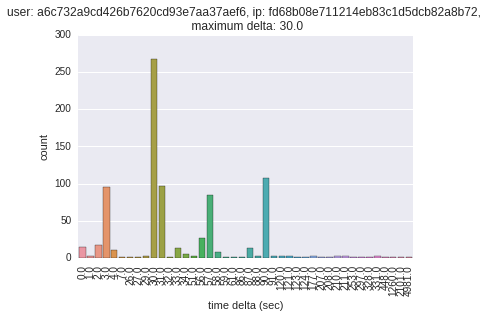

In [27]:
# Посчитаем распределение разниц во времени между соединениями для каждой пары
#
# и запомним те, у кого самое частое расстояние между запросами > 2 сек 
# и таких соединений было минимум 250, 
# т.е. кто чаще всего инициирует соединения периодически.
anomaly_conns = []

for pair in l_user_ip_pair[:1000]: # для ускорения обработки можно ограничиться первыми n: l_user_ip_pair[:1000]
    user, ip = pair.split(' ')
    df_u = df_user_ip_pair[(df_user_ip_pair.src_user == user) & (df_user_ip_pair.dest_ip == ip)]
    if not df_u.empty:
        a_ = df_u.groupby('time_delta_sec')['_time'].count().sort_values(ascending=False)
        if a_.index[0] not in [0., 1., 2.] and a_[a_.index[0]] >= 250:
            anomaly_conns.append(pair)
            x = a_.reset_index()['time_delta_sec']
            y = a_.reset_index()['_time']
            plt.figure()
            ax = sns.barplot(x, y)
            ax.set_title("user: {}, ip: {}, \n maximum delta: {}".format(user, ip, a_.index[0]))
            ax.set(xlabel='time delta (sec)', ylabel='count', )
            plt.setp(ax.get_xticklabels(), rotation=90)

In [28]:
len(anomaly_conns)

18

In [29]:
anomaly_conns

['33aecf54a8eab5d1c06b2dce27dec355 3e2c1b09ab7a814378d0481fb770096b',
 '22e94d0520b9f9b2f02eaa97b165f720 7a7c3f300017bc4b6cc78caa50aada0c',
 'ec0d21471f0feba0ff59b3e7c2cc548b 8b18e5b2226301729de38d825c4f8564',
 '3315aea8ce0bfbdee834f2043157ccce 7a7c3f300017bc4b6cc78caa50aada0c',
 '36d99d1b971989cab847688241faefc2 4b744213664ce6597faec2f767d2b9d2',
 '33aecf54a8eab5d1c06b2dce27dec355 307d6cbf8ae0f15371e42e9a69d39f31',
 '567186b9acb3ba4dc013fbdb5380b441 c6bf804b15719bed9abb7cf4477cf664',
 '64c5eae485561a1d7064477e792a6358 4b744213664ce6597faec2f767d2b9d2',
 '0f0c129694085ab9c5ad2e7a9c28378c 7a7c3f300017bc4b6cc78caa50aada0c',
 '64c5eae485561a1d7064477e792a6358 059f384dcc3db35ae53f4eb5b9e15986',
 'a6c732a9cd426b7620cd93e7aa37aef6 4b744213664ce6597faec2f767d2b9d2',
 'd5e09496e64f5ddc037f19a44b45ad8b 7a7c3f300017bc4b6cc78caa50aada0c',
 '411d7413265b917af5ecedc54bda14ef 74237baa51aae816cd02ec35b3d47bd3',
 '64c5eae485561a1d7064477e792a6358 c6bf804b15719bed9abb7cf4477cf664',
 '36d99d1b971989cab8

Сразу же видим паттерны для пользователя 33aecf54a8eab5d1c06b2dce27dec355, соединяющегося с адресом 33aecf54a8eab5d1c06b2dce27dec355 каждые 60 секунд.

Смотрим подробнее:

In [30]:
df_user_ip_pair[(df_user_ip_pair.src_user == '33aecf54a8eab5d1c06b2dce27dec355') \
                & (df_user_ip_pair.dest_ip == '3e2c1b09ab7a814378d0481fb770096b') \
                & (df_user_ip_pair['time_delta_sec'] == 60)]

,_time,src_user,src_ip,src_port,dest_user,dest_ip,dest_port,input_byte,output_byte,time_delta,time_delta_sec
2370637,2018-01-18 18:34:54,33aecf54a8eab5d1c06b2dce27dec355,1ddc2b40eee61ab2783073ebd50a0254,52808,na,3e2c1b09ab7a814378d0481fb770096b,443,171,179,00:01:00,60.0
2356442,2018-01-18 18:36:55,33aecf54a8eab5d1c06b2dce27dec355,1ddc2b40eee61ab2783073ebd50a0254,52808,na,3e2c1b09ab7a814378d0481fb770096b,443,171,179,00:01:00,60.0
2356010,2018-01-18 18:37:55,33aecf54a8eab5d1c06b2dce27dec355,1ddc2b40eee61ab2783073ebd50a0254,52808,na,3e2c1b09ab7a814378d0481fb770096b,443,171,179,00:01:00,60.0
2365376,2018-01-18 18:38:55,33aecf54a8eab5d1c06b2dce27dec355,1ddc2b40eee61ab2783073ebd50a0254,52808,na,3e2c1b09ab7a814378d0481fb770096b,443,171,179,00:01:00,60.0
2297806,2018-01-18 18:39:55,33aecf54a8eab5d1c06b2dce27dec355,1ddc2b40eee61ab2783073ebd50a0254,52808,na,3e2c1b09ab7a814378d0481fb770096b,443,171,179,00:01:00,60.0
2254672,2018-01-18 18:54:29,33aecf54a8eab5d1c06b2dce27dec355,1ddc2b40eee61ab2783073ebd50a0254,52808,na,3e2c1b09ab7a814378d0481fb770096b,443,171,179,00:01:00,60.0
2340571,2018-01-18 19:00:56,33aecf54a8eab5d1c06b2dce27dec355,1ddc2b40eee61ab2783073ebd50a0254,52808,na,3e2c1b09ab7a814378d0481fb770096b,443,171,179,00:01:00,60.0
2317608,2018-01-18 19:52:49,33aecf54a8eab5d1c06b2dce27dec355,1ddc2b40eee61ab2783073ebd50a0254,57540,na,3e2c1b09ab7a814378d0481fb770096b,443,171,179,00:01:00,60.0
2317300,2018-01-18 19:53:49,33aecf54a8eab5d1c06b2dce27dec355,1ddc2b40eee61ab2783073ebd50a0254,57540,na,3e2c1b09ab7a814378d0481fb770096b,443,171,179,00:01:00,60.0
2278091,2018-01-18 19:54:49,33aecf54a8eab5d1c06b2dce27dec355,1ddc2b40eee61ab2783073ebd50a0254,57540,na,3e2c1b09ab7a814378d0481fb770096b,443,171,179,00:01:00,60.0


Видим периодичный HTTPS трафик с небольшим количеством переданных и принятых байт. Если данная активность не является частью бизнес-процессов и адрес dst_ip - внешний, то существует вероятность присутствия у пользователя агента, связывающегося с CnC.

Конечно, чтобы сделать окончательный вывод, нужно смотреть на реальные адреса, их репутацию и логи прокси-сервера, заголовки запросов/ответов, логи IDS.

Ниже еще 1 пример периодических соединений (443/tcp).

In [31]:
df_user_ip_pair[(df_user_ip_pair.src_user == '22e94d0520b9f9b2f02eaa97b165f720') \
                & (df_user_ip_pair.dest_ip == '7a7c3f300017bc4b6cc78caa50aada0c') \
                & (df_user_ip_pair['time_delta_sec'] == 20)]

,_time,src_user,src_ip,src_port,dest_user,dest_ip,dest_port,input_byte,output_byte,time_delta,time_delta_sec
2289182,2018-01-18 20:06:03,22e94d0520b9f9b2f02eaa97b165f720,4497cb2c4799b363a6e39801e4f3278b,64705,na,7a7c3f300017bc4b6cc78caa50aada0c,443,1561,5566,00:00:20,20.0
2231080,2018-01-18 20:12:37,22e94d0520b9f9b2f02eaa97b165f720,4497cb2c4799b363a6e39801e4f3278b,64705,na,7a7c3f300017bc4b6cc78caa50aada0c,443,1561,5618,00:00:20,20.0
2022031,2018-01-19 06:22:03,22e94d0520b9f9b2f02eaa97b165f720,084d1f78913059162dc163880d67ee4c,52205,na,7a7c3f300017bc4b6cc78caa50aada0c,443,1330,887,00:00:20,20.0
1998962,2018-01-19 06:22:23,22e94d0520b9f9b2f02eaa97b165f720,084d1f78913059162dc163880d67ee4c,52215,na,7a7c3f300017bc4b6cc78caa50aada0c,443,1318,847,00:00:20,20.0
1992687,2018-01-19 06:22:43,22e94d0520b9f9b2f02eaa97b165f720,084d1f78913059162dc163880d67ee4c,52229,na,7a7c3f300017bc4b6cc78caa50aada0c,443,1561,5566,00:00:20,20.0
1992543,2018-01-19 06:23:03,22e94d0520b9f9b2f02eaa97b165f720,084d1f78913059162dc163880d67ee4c,52251,na,7a7c3f300017bc4b6cc78caa50aada0c,443,1549,5578,00:00:20,20.0
1992417,2018-01-19 06:23:23,22e94d0520b9f9b2f02eaa97b165f720,084d1f78913059162dc163880d67ee4c,52311,na,7a7c3f300017bc4b6cc78caa50aada0c,443,1613,5566,00:00:20,20.0
2004715,2018-01-19 06:23:43,22e94d0520b9f9b2f02eaa97b165f720,084d1f78913059162dc163880d67ee4c,52381,na,7a7c3f300017bc4b6cc78caa50aada0c,443,1330,887,00:00:20,20.0
2004461,2018-01-19 06:24:03,22e94d0520b9f9b2f02eaa97b165f720,084d1f78913059162dc163880d67ee4c,52385,na,7a7c3f300017bc4b6cc78caa50aada0c,443,1613,5670,00:00:20,20.0
2003913,2018-01-19 06:24:23,22e94d0520b9f9b2f02eaa97b165f720,084d1f78913059162dc163880d67ee4c,52390,na,7a7c3f300017bc4b6cc78caa50aada0c,443,1561,5618,00:00:20,20.0


## Задача 4

Поиск регулярных запросов (запросов выполняющихся периодически) по полю src_ip

Выполняем по аналогии с п.3, причем сразу используем агрегацию по паре (src_ip, dest_ip)

### Агрегация по паре (src_ip, dest_ip)

In [32]:
# Составим список пар (src_ip, dest_ip)
src_dst_ip = df.groupby(['src_ip', 'dest_ip']).count().sort_values('_time', ascending=False).reset_index()[['src_ip', 'dest_ip', '_time']]
src_dst_ip.head()

,src_ip,dest_ip,_time
0,d02c9bb2cade1c33ff985188acc96e68,072f83db38ddd013e59a3616bd3b05a6,37386
1,3f491769846e92a9e9e1afec2321b5ae,0956783fe5a6d8e0f864b5eaf4084063,35092
2,43ed6a1c781031fa618c0350a801e52f,0956783fe5a6d8e0f864b5eaf4084063,23520
3,55ec3201eaddfc3359265c69bc1db61a,0956783fe5a6d8e0f864b5eaf4084063,16409
4,bf3bf0d614665e79f7233bdf0bcbf4da,0956783fe5a6d8e0f864b5eaf4084063,14162


In [33]:
print("Уникальных пар: {}".format(src_dst_ip.shape[0]))

Уникальных пар: 137937


In [34]:
src_dst_ip['ip_pair'] = src_dst_ip.apply(lambda r: "{} {}".format(r['src_ip'], r['dest_ip']), axis=1)

In [35]:
l_ip_pair = list(src_dst_ip['ip_pair'])

In [36]:
len(l_ip_pair)

137937

In [37]:
src_dst_ip.head()

,src_ip,dest_ip,_time,ip_pair
0,d02c9bb2cade1c33ff985188acc96e68,072f83db38ddd013e59a3616bd3b05a6,37386,d02c9bb2cade1c33ff985188acc96e68 072f83db38ddd...
1,3f491769846e92a9e9e1afec2321b5ae,0956783fe5a6d8e0f864b5eaf4084063,35092,3f491769846e92a9e9e1afec2321b5ae 0956783fe5a6d...
2,43ed6a1c781031fa618c0350a801e52f,0956783fe5a6d8e0f864b5eaf4084063,23520,43ed6a1c781031fa618c0350a801e52f 0956783fe5a6d...
3,55ec3201eaddfc3359265c69bc1db61a,0956783fe5a6d8e0f864b5eaf4084063,16409,55ec3201eaddfc3359265c69bc1db61a 0956783fe5a6d...
4,bf3bf0d614665e79f7233bdf0bcbf4da,0956783fe5a6d8e0f864b5eaf4084063,14162,bf3bf0d614665e79f7233bdf0bcbf4da 0956783fe5a6d...


In [38]:
# Отсортируем все запросы по времени
df_ip = df[(df.src_ip != 'na') & (df.dest_ip != 'na')].sort_values(by='_time')

In [39]:
df_ip.shape

(2394105, 9)

In [40]:
# Найдем разницу во времени между запросами отдельно для каждой пары 
# Начнем с наиболее встречающихся пар
df_ip['time_delta'] = df_ip['output_byte'].apply(lambda x: 0)
for i, pair in enumerate(l_ip_pair[:1000]): # для ускорения обработки можно ограничиться первыми n: l_ip_pair[:1000]
    src, dst = pair.split(' ')
    df_ip['time_delta'].update(df_ip[(df_ip.src_ip == src) & (df_ip.dest_ip == dst)]['_time'].diff())

In [41]:
# Переведем все дельты в секунды
df_ip['time_delta_sec'] = df_ip['time_delta'] / np.timedelta64(1, 's')
df_ip['time_delta_sec'].fillna(0, inplace=True)

In [42]:
df_ip.head()

,_time,src_user,src_ip,src_port,dest_user,dest_ip,dest_port,input_byte,output_byte,time_delta,time_delta_sec
2386235,2018-01-18 18:00:00,f2825c1deb48cc723dc27b598c662610,43ed6a1c781031fa618c0350a801e52f,41564,na,e3ec35262a27486da55813ba91a9b34b,443,579,2678,0 days,0.0
2392245,2018-01-18 18:00:00,efdb5488cc509caff4c2de4654240f9d,f32ed332994d599e45b8bdbfc8d1da7d,57642,na,fcd0434af03dc92feebc396d5315bd80,143,2070,2566,0 days,0.0
2392244,2018-01-18 18:00:00,3f341362e80f676a3602d726e73ef94d,45c9c56fc54a8549b6a4ed19c97bbaf5,49888,na,e3ec35262a27486da55813ba91a9b34b,443,0,157,0 days,0.0
2392243,2018-01-18 18:00:00,na,44b65246efc05ac2c96fe955b4108815,51026,7b0a6f66cc5978249d9556d08f221c53,7ef76dc579f551f3bcb63cfa0438b1c4,23,40,0,0 days,0.0
2392242,2018-01-18 18:00:00,na,5be64d6e523e2172b74ca24ab859fce2,59353,efdb5488cc509caff4c2de4654240f9d,f32ed332994d599e45b8bdbfc8d1da7d,6914,40,0,0 days,0.0


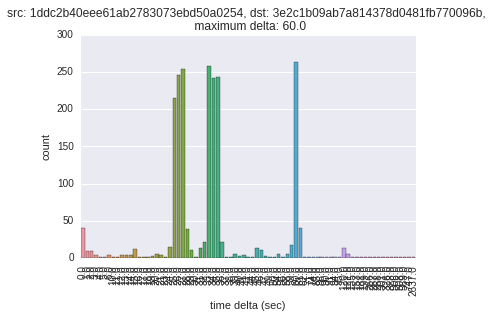

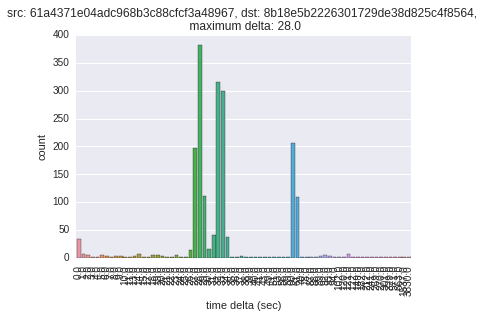

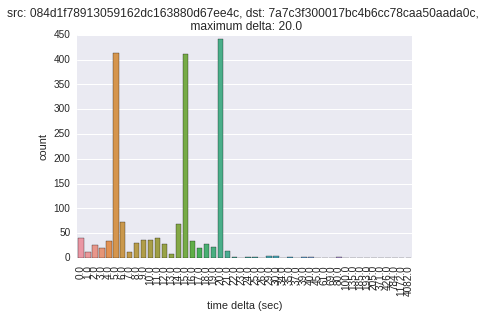

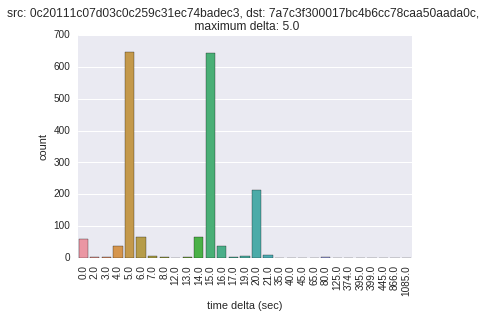

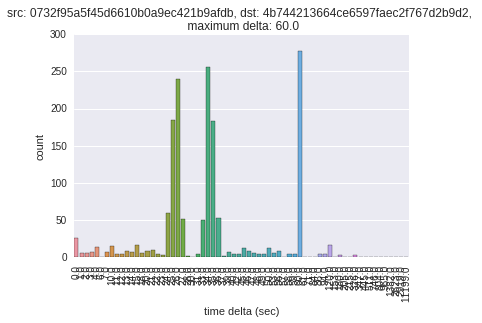

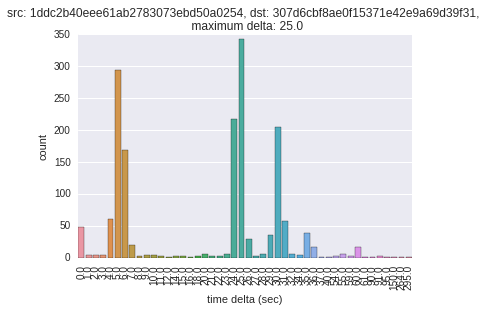

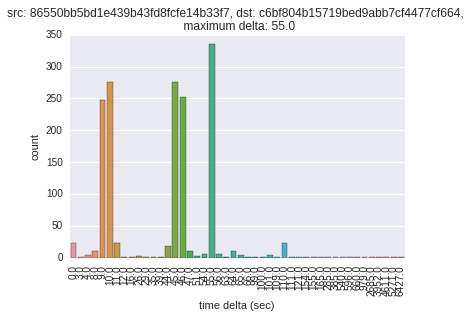

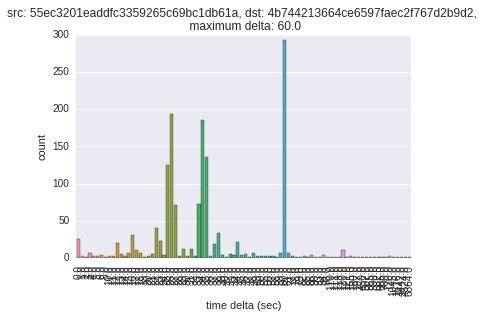

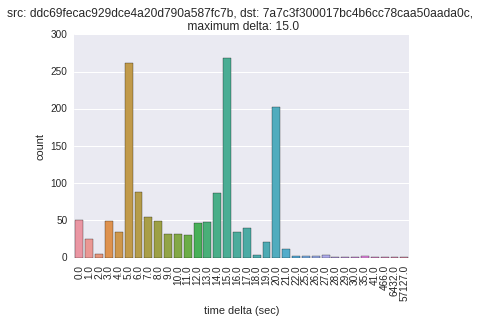

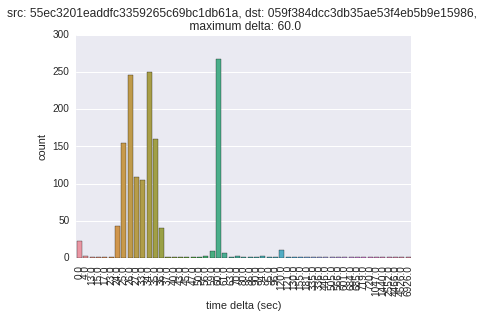

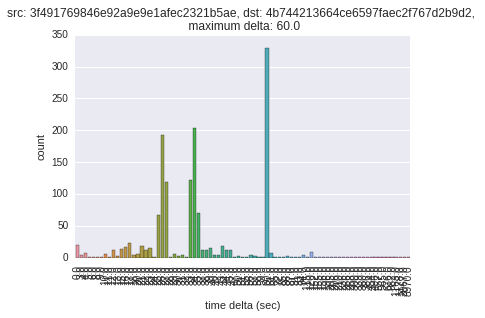

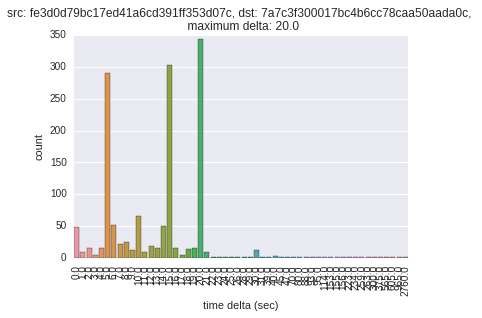

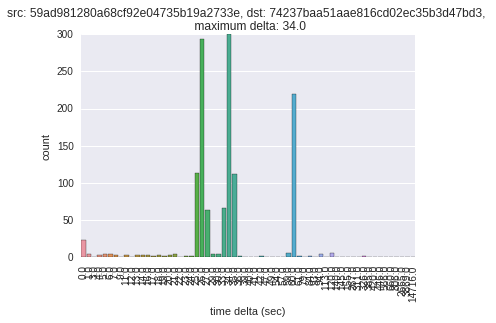

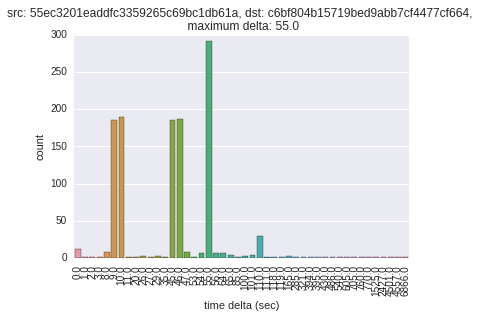

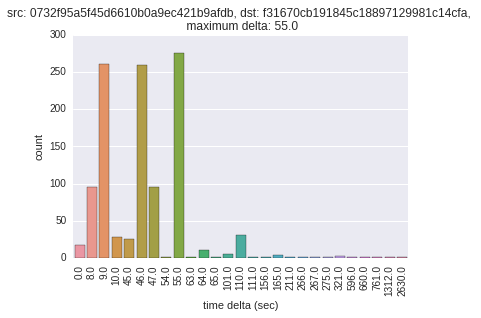

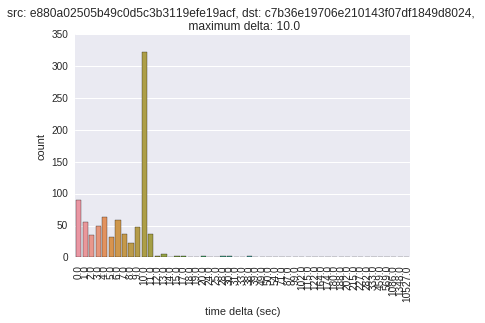

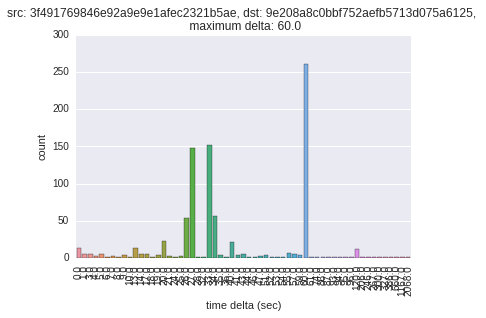

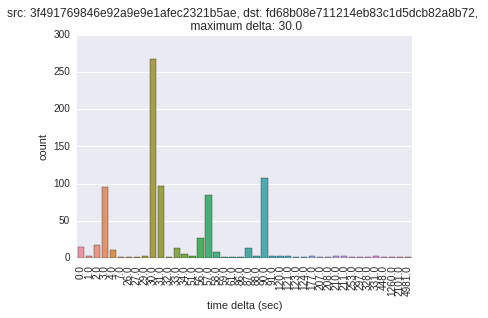

In [43]:
# Посчитаем распределение разниц во времени между соединениями для каждой пары
#
# и запомним те, у кого самое частое расстояние между запросами > 2 сек 
# и таких соединений было минимум 250, 
# т.е. кто чаще всего инициирует соединения периодически.
anomaly_conns_ip = []

for pair in l_ip_pair[:1000]:  # для ускорения обработки можно ограничиться первыми n: l_ip_pair[:1000]
    src, dst = pair.split(' ')
    df_u = df_ip[(df_ip.src_ip == src) & (df_ip.dest_ip == dst)]
    if not df_u.empty:
        a_ = df_u.groupby('time_delta_sec')['_time'].count().sort_values(ascending=False)
        if a_.index[0] not in [0., 1., 2.] and a_[a_.index[0]] >= 250:
            anomaly_conns_ip.append(pair)
            x = a_.reset_index()['time_delta_sec']
            y = a_.reset_index()['_time']
            plt.figure()
            ax = sns.barplot(x, y)
            ax.set_title("src: {}, dst: {}, \n maximum delta: {}".format(src, dst, a_.index[0]))
            ax.set(xlabel='time delta (sec)', ylabel='count', )
            plt.setp(ax.get_xticklabels(), rotation=90)

In [44]:
anomaly_conns_ip

['1ddc2b40eee61ab2783073ebd50a0254 3e2c1b09ab7a814378d0481fb770096b',
 '61a4371e04adc968b3c88cfcf3a48967 8b18e5b2226301729de38d825c4f8564',
 '084d1f78913059162dc163880d67ee4c 7a7c3f300017bc4b6cc78caa50aada0c',
 '0c20111c07d03c0c259c31ec74badec3 7a7c3f300017bc4b6cc78caa50aada0c',
 '0732f95a5f45d6610b0a9ec421b9afdb 4b744213664ce6597faec2f767d2b9d2',
 '1ddc2b40eee61ab2783073ebd50a0254 307d6cbf8ae0f15371e42e9a69d39f31',
 '86550bb5bd1e439b43fd8fcfe14b33f7 c6bf804b15719bed9abb7cf4477cf664',
 '55ec3201eaddfc3359265c69bc1db61a 4b744213664ce6597faec2f767d2b9d2',
 'ddc69fecac929dce4a20d790a587fc7b 7a7c3f300017bc4b6cc78caa50aada0c',
 '55ec3201eaddfc3359265c69bc1db61a 059f384dcc3db35ae53f4eb5b9e15986',
 '3f491769846e92a9e9e1afec2321b5ae 4b744213664ce6597faec2f767d2b9d2',
 'fe3d0d79bc17ed41a6cd391ff353d07c 7a7c3f300017bc4b6cc78caa50aada0c',
 '59ad981280a68cf92e04735b19a2733e 74237baa51aae816cd02ec35b3d47bd3',
 '55ec3201eaddfc3359265c69bc1db61a c6bf804b15719bed9abb7cf4477cf664',
 '0732f95a5f45d6610b

## Задача 5

Рассматривая события сетевого трафика как символы неизвестного языка, найти 5 наиболее устойчивых N-грамм журнала событий (текста на неизвестном языке), (https://ru.wikipedia.org/wiki/N-грамм), где N=3-5. Тип символа задается квартетом user+src_port+dest_ip+dest_port.

In [45]:
df['symbol'] = df.apply(lambda r: "({} {} {} {})".format(r.src_user, r.src_port, r.dest_ip, r.dest_port), axis=1)

In [46]:
df['symbol'].head()

0    (c15cf96d9b56740c974661d209ef44f7 55991 1f1b55...
1    (c15cf96d9b56740c974661d209ef44f7 55979 353a9f...
2    (c15cf96d9b56740c974661d209ef44f7 34432 072f83...
3    (c15cf96d9b56740c974661d209ef44f7 49932 072f83...
4    (c15cf96d9b56740c974661d209ef44f7 55994 ee76d4...
Name: symbol, dtype: object

In [47]:
###
# Source: https://gist.github.com/benhoyt/dfafeab26d7c02a52ed17b6229f0cb52
###

import collections
import re
import sys
import time


def tokenize(string):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    return re.findall(u'\(.*?\)', string)


def count_ngrams(lines, min_length=3, max_length=5):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams


def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-grams -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
    print('')

In [48]:
lines = list(df['symbol'])

In [49]:
ngrams = count_ngrams(lines)

In [50]:
print_most_frequent(ngrams, 5)

----- 5 most common 3-grams -----
(a3e47aed07abf4475dbbc0668abf31c7 38237 072f83db38ddd013e59a3616bd3b05a6 53) (12a561cb1749cf76bf2074d74b05f54f 50606 072f83db38ddd013e59a3616bd3b05a6 53) (12a561cb1749cf76bf2074d74b05f54f 50606 0956783fe5a6d8e0f864b5eaf4084063 53): 94
(a3e47aed07abf4475dbbc0668abf31c7 38237 072f83db38ddd013e59a3616bd3b05a6 53) (12a561cb1749cf76bf2074d74b05f54f 50606 0956783fe5a6d8e0f864b5eaf4084063 53) (12a561cb1749cf76bf2074d74b05f54f 50606 072f83db38ddd013e59a3616bd3b05a6 53): 48
(a3e47aed07abf4475dbbc0668abf31c7 38237 0956783fe5a6d8e0f864b5eaf4084063 53) (ec0d21471f0feba0ff59b3e7c2cc548b 43796 072f83db38ddd013e59a3616bd3b05a6 53) (a3e47aed07abf4475dbbc0668abf31c7 38237 072f83db38ddd013e59a3616bd3b05a6 53): 44
(a3e47aed07abf4475dbbc0668abf31c7 38237 0956783fe5a6d8e0f864b5eaf4084063 53) (a3e47aed07abf4475dbbc0668abf31c7 38237 072f83db38ddd013e59a3616bd3b05a6 53) (12a561cb1749cf76bf2074d74b05f54f 50606 072f83db38ddd013e59a3616bd3b05a6 53): 39
(ec0d21471f0feba0ff59b3e7c